In [64]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk


In [24]:
BATCH_SIZE = 8
LR = 3e-5
NUM_EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# BATCH_SIZE = 8
# LR = 3e-5
# NUM_EPOCHS = 10

# second best
# BATCH_SIZE = 16
# LR = 3e-5
# NUM_EPOCHS = 10

# BATCH_SIZE = 16
# LR = 2e-5
# NUM_EPOCHS = 10


# BATCH_SIZE = 16
# LR = 5e-5
# NUM_EPOCHS = 10

#best
# BATCH_SIZE = 8
# LR = 2e-5
# NUM_EPOCHS = 10
# EARLY_STOPPING_PATIENCE = 5

# BATCH_SIZE = 16
# LR = 1e-5
# NUM_EPOCHS = 10

# BATCH_SIZE = 8
# LR = 1e-5
# NUM_EPOCHS = 10

In [25]:
data = pd.read_csv('/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/data/training_data/train_data.csv')
data['Label'] = (data['Label'] == 'PRODUCT').astype(int)
data['Text'] = data['Text'].str.title()

print(data.head(3))

                             Text  Label
0           Alf & Bud Side Tables      1
1  Simja 6 Piece Alfresco Setting      1
2               Marini Nightstand      1


In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_data = tokenizer(list(data['Text']), truncation=True, padding=True, return_tensors='pt', max_length=128)

labels = torch.tensor(list(data['Label']))

dataset = torch.utils.data.TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=42)


In [27]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
loss_fn = torch.nn.BCEWithLogitsLoss()

best_val_loss = float('inf')
early_stopping_counter = 0

/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/.venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.07989008392905816
Validation Loss: 0.3906785547733307
Epoch 2/10, Training Loss: 0.01712699899508152
Validation Loss: 0.3920044004917145
Epoch 3/10, Training Loss: 0.021422544756205752
Validation Loss: 0.3971676230430603
Epoch 4/10, Training Loss: 0.02161593415075913
Validation Loss: 0.39286375045776367
Epoch 00004: reducing learning rate of group 0 to 3.0000e-06.
Epoch 5/10, Training Loss: 0.012730944930808619
Validation Loss: 0.3919807970523834
Epoch 6/10, Training Loss: 0.01645190778071992
Validation Loss: 0.3915420472621918
Early stopping after 6 epochs


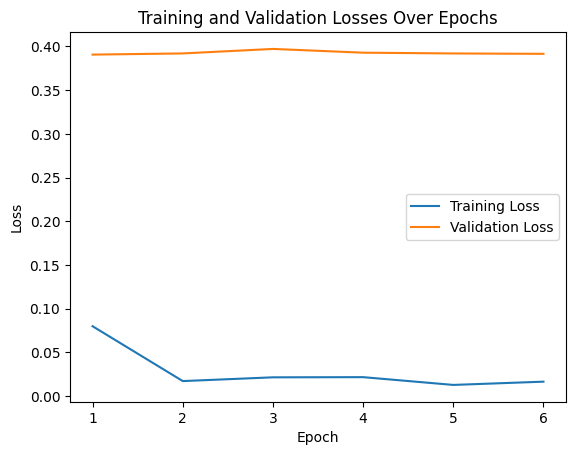

In [29]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1).float())
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate and store training loss
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Training Loss: {train_loss}')

    model.eval()
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits.squeeze())

            val_predictions.extend(predictions.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = loss_fn(torch.tensor(val_predictions).squeeze(), torch.tensor(val_labels).float())
    val_losses.append(val_loss.item())

    print(f'Validation Loss: {val_loss}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f'Early stopping after {epoch + 1} epochs')
            break

epochs = np.arange(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

In [59]:
model.save_pretrained('furniture_model1')

In [ ]:
loaded_model = BertForSequenceClassification.from_pretrained('furniture_model1')

def predict_text(model, text, threshold=0.5):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt', max_length=128)
    outputs = loaded_model(**inputs)
    prediction = torch.sigmoid(outputs.logits.squeeze()).item()

    print(f"Predicted Probability: {prediction}")

    if prediction >= threshold:
        print("Predicted Label: Furniture")
        return True
    else:
        print("Predicted Label: Not Furniture")
        return False

predict_text(loaded_model, "Chaos Theory Kavi Bandi Area Rug", threshold=0.735)

In [78]:
file_path = "/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/data/test_data/test_h_data.txt"
merged_df = pd.read_csv('/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/data/merged_data.csv')
with open(file_path, 'r') as file:
    lines = file.read().splitlines()

In [79]:
def check_string_present(s, df):
    is_present = df['Text'].isin([s])
    if is_present.any():
        return True
    else:
        return False
    
def check_len(s):
    tokens = nltk.word_tokenize(s)
    tokens = [word for word in tokens if word.isalpha()]
    return len(tokens) <= 1
    
def contains_verb_adverb_pronoun_in_context(sentence):
        
        if check_len(sentence):
            return True
        
        def has_furniture_name(s):
            furniture_list = [
                "chair", "table", "desk", "stool", "bench", "shelf", "cabinet", "bed", 
                "sofa", "ottoman", "dresser", "wardrobe", "nightstand", "sideboard", 
                "bookcase", "buffet", "etagere", "chaise", "barstool", 
                "couch", "mirror", "lamp", "candlestand", "drawer", "armoire", 
                "vanity", "bookshelf", "cupboard", "recliner", "stand",
                "settee", "rockingchair", "futon", "chifforobe", "daybed", 
                "tuffet",  "bookstand", "bedstead", "mattress", "coffeetable", "armchair", 
                "ottoman", "bench", "sofa",  "recliner" "rug", "mat", "carpet"
            ]
            tokens = nltk.word_tokenize(s)
            for token in tokens:
                if token.lower() in furniture_list:
                    return True
            
        nlp = spacy.load("en_core_web_sm")
        doc = nlp(sentence)

        if any(token.pos_ in ["VERB", "ADV", "PRON"] for token in doc):
            if not has_furniture_name(sentence):
                return True

        if any(token.head.pos_ in ["VERB", "ADV", "PRON"] for token in doc):
            if not has_furniture_name(sentence):
                return True

        if any(token.dep_ == "amod" and token.head.pos_ in ["VERB", "ADV", "PRON"] for token in doc):
            if not has_furniture_name(sentence):
                return True

        if any(child.pos_ in ["VERB", "ADV", "PRON"] for token in doc for child in token.children):
            if not has_furniture_name(sentence):
                return True

        if any(sibling.pos_ in ["VERB", "ADV", "PRON"] for token in doc for sibling in token.head.children if sibling != token):
            if not has_furniture_name(sentence):
                return True

        return False

In [80]:
for sentence in lines:
    if sentence != "" and predict_text(loaded_model, sentence, threshold=0.735) and not contains_verb_adverb_pronoun_in_context(sentence):
        if not check_string_present(sentence, merged_df):
            new_row = pd.DataFrame([[sentence, "PRODUCT"]], columns=['Text', 'Label'])
            merged_df = pd.concat([merged_df,new_row], ignore_index = True)
            merged_df.to_csv("/Users/vladcalomfirescu/Desktop/MyFiles/DEV/ML/Veridion-Project/data/merged_data.csv", index=False)


Predicted Probability: 0.713563084602356
Predicted Label: Not Furniture
Predicted Probability: 0.7340219616889954
Predicted Label: Not Furniture
Predicted Probability: 0.7299138307571411
Predicted Label: Not Furniture
Predicted Probability: 0.7275010347366333
Predicted Label: Not Furniture
Predicted Probability: 0.7231777906417847
Predicted Label: Not Furniture
Predicted Probability: 0.7216533422470093
Predicted Label: Not Furniture
Predicted Probability: 0.7216210961341858
Predicted Label: Not Furniture
Predicted Probability: 0.7406299114227295
Predicted Label: Furniture
Predicted Probability: 0.7236394882202148
Predicted Label: Not Furniture
Predicted Probability: 0.732206404209137
Predicted Label: Not Furniture
Predicted Probability: 0.7146645188331604
Predicted Label: Not Furniture
Predicted Probability: 0.7262696623802185
Predicted Label: Not Furniture
Predicted Probability: 0.7206608653068542
Predicted Label: Not Furniture
Predicted Probability: 0.7312917113304138
Predicted Label